In [1]:
import torch
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from model import Model
import argparse
import os
from time import time
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
MODEL_PATH = "../models/gen-5"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "../inputs/nyu_data/data/nyu2_test"

In [3]:
# Load models
depth_model_0 = Model().to(DEVICE)
depth_model_0.load_state_dict(
    torch.load(f"{MODEL_PATH}/0.pth", map_location=DEVICE, weights_only=True)
)

depth_model_1 = Model().to(DEVICE)
depth_model_1.load_state_dict(
    torch.load(f"{MODEL_PATH}/1.pth", map_location=DEVICE, weights_only=True)
)

depth_model_2 = Model().to(DEVICE)
depth_model_2.load_state_dict(
    torch.load(f"{MODEL_PATH}/2.pth", map_location=DEVICE, weights_only=True)
)

depth_model_3 = Model().to(DEVICE)
depth_model_3.load_state_dict(
    torch.load(f"{MODEL_PATH}/3.pth", map_location=DEVICE, weights_only=True)
)

<All keys matched successfully>

In [4]:
image_data = {}

# Read images from the given path
image_files = os.listdir(DATA_PATH)

# Classify and store images based on their endings
for image_file in tqdm(image_files, desc="Processing images"):
    image_name, ext = os.path.splitext(image_file)
    key = image_name.split("_")[0]  # Extract the part before '_'

    image_path = os.path.join(DATA_PATH, image_file)

    if image_file.endswith("_depth.png"):
        if key in image_data:
            image_data[key] = (image_data[key][0], cv2.imread(image_path))
        else:
            image_data[key] = (None, cv2.imread(image_path))

    elif image_file.endswith("_colors.png"):
        if key in image_data:
            image_data[key] = (cv2.imread(image_path), image_data[key][1])
        else:
            image_data[key] = (cv2.imread(image_path), None)

Processing images: 100%|██████████| 1308/1308 [00:08<00:00, 157.34it/s]


In [5]:
outputs = []

for key, (color_img, ground_truth) in tqdm(image_data.items(), desc="Evaluating"):

    image_tensor = (
        torch.from_numpy(cv2.resize(color_img, (320, 240)))
        .float()
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(DEVICE)
    )

    with torch.no_grad():
        predicted = depth_model_3(image_tensor).cpu().squeeze().numpy()

    outputs.append((color_img, ground_truth, predicted))

Evaluating: 100%|██████████| 654/654 [00:26<00:00, 24.83it/s]


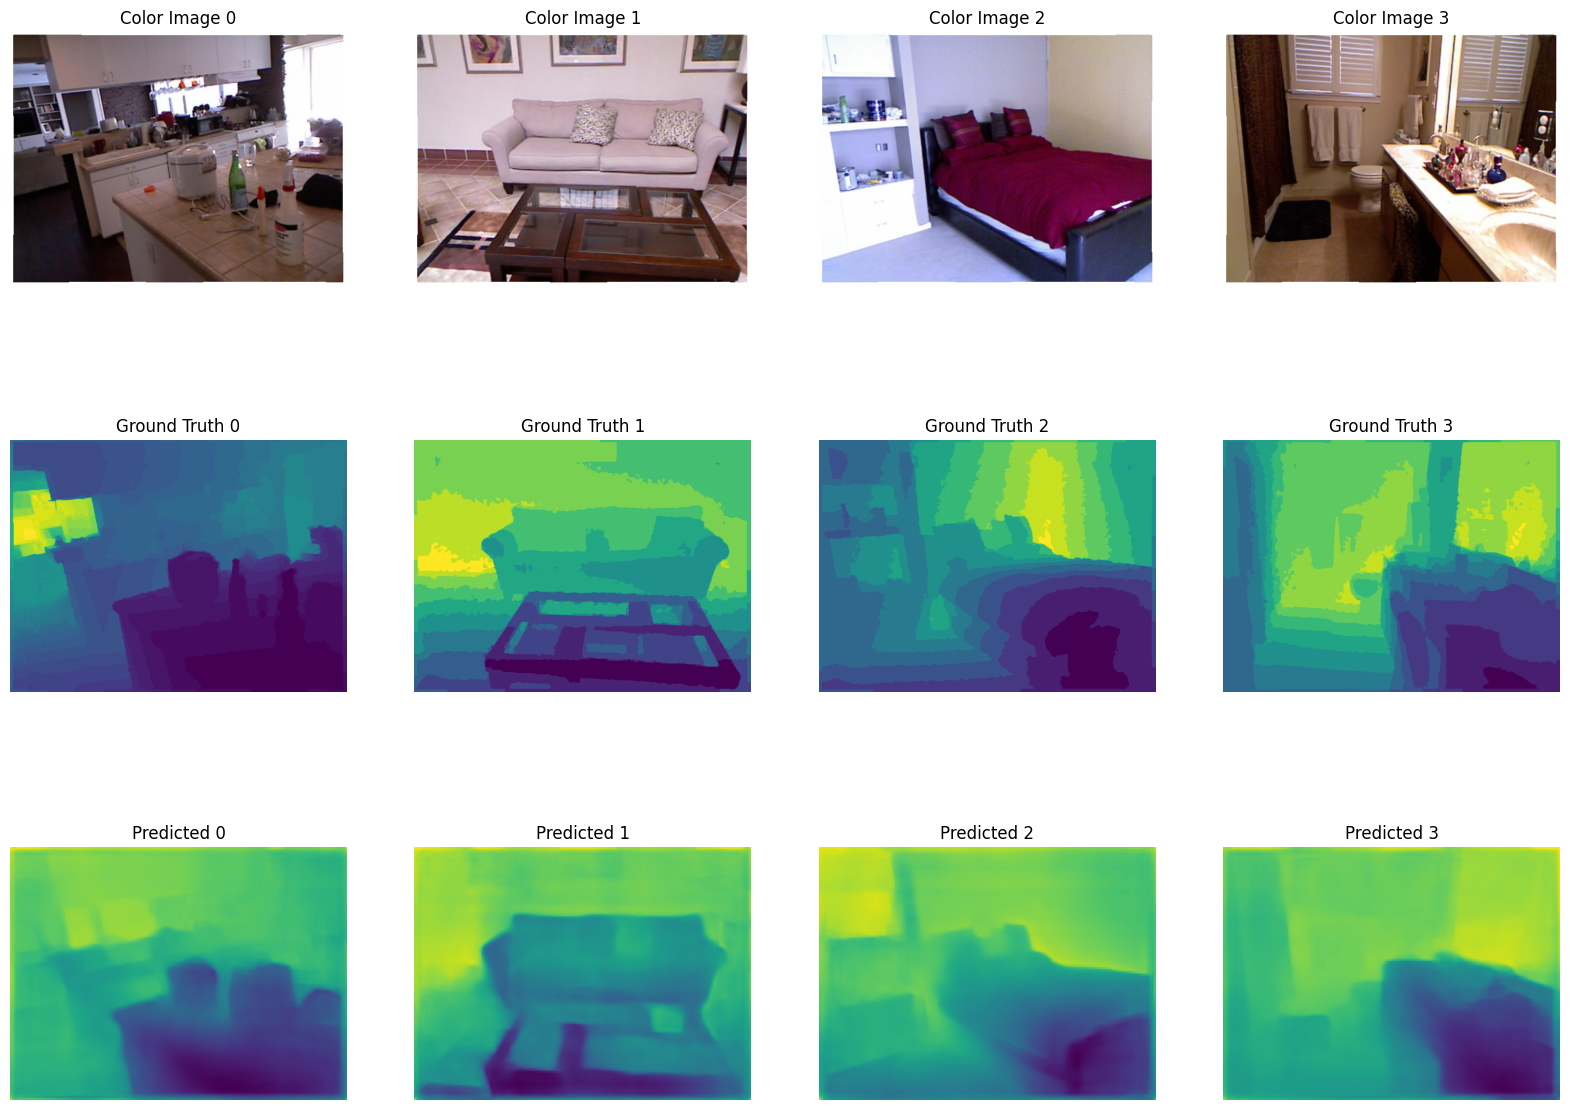

In [6]:
# Create a 3x4 grid for plotting
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, (color_img, ground_truth, predicted) in enumerate(outputs):
    if i == 4:  # Display only the first 12 triplets (adjust based on your grid size)
        break

    # Convert color_img to RGB for matplotlib
    color_img_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

    # Display color image
    axs[0, i].imshow(color_img_rgb)
    axs[0, i].set_title(f"Color Image {i}")
    axs[0, i].axis("off")

    # Display ground truth image (assumed to be grayscale)
    axs[1, i].imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY), cmap="viridis")
    axs[1, i].set_title(f"Ground Truth {i}")
    axs[1, i].axis("off")

    # Display predicted image (assumed to be grayscale)
    axs[2, i].imshow(1 - predicted, cmap="viridis")
    axs[2, i].set_title(f"Predicted {i}")
    axs[2, i].axis("off")

In [7]:
def calculate_rmse(gt_image, predicted_image):
    gt_image = np.array(gt_image, dtype=np.float32)
    predicted_image = np.array(predicted_image, dtype=np.float32)

    # Convert GT image to grayscale if it isn't already
    if len(gt_image.shape) == 3:
        gt_image = cv2.cvtColor(gt_image, cv2.COLOR_RGB2GRAY)

    # Avoid division by zero by replacing zeros in the GT image with a small value
    gt_image = np.where(gt_image == 0, 1e-10, gt_image)

    # Resize predicted image to match the ground truth image
    predicted_image = cv2.resize(
        predicted_image,
        (gt_image.shape[1], gt_image.shape[0]),
        interpolation=cv2.INTER_LINEAR
    )

    # Median scaling step: scale the predicted depth map to match the median of the ground truth
    median_gt = np.median(gt_image)
    median_predicted = np.median(predicted_image)

    # Avoid division by zero for predicted median
    if median_predicted != 0:
        scale_factor = median_gt / median_predicted
        predicted_image *= scale_factor

    # Calculate squared difference between the ground truth and predicted images
    squared_diff = (gt_image - predicted_image) ** 2

    # Compute Mean Squared Error
    mean_squared_error = np.mean(squared_diff)

    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error)

    return rmse

In [8]:
total_rmse = 0
num_images = len(outputs)

# Iterate through all images and accumulate RMSE
for i, (color_img, ground_truth, predicted) in enumerate(outputs):
    total_rmse += calculate_rmse(ground_truth, predicted)

# Calculate average RMSE over all images
average_rmse = total_rmse

print(f"Average RMSE: {average_rmse / i}")

Average RMSE: 6.126220345132019
